Before doing ML I need a simple estimator that can also easily filter off ships that are not of interest!
For this I think the most relevant variable will be the distance to the bridge
This may also be a relevant variable for an ML algorithm as it will provide direct information about the geometry of the problem

1) Check if the ship is in the corridor defined by going perpendicular to the bridge\
2a) if yes, take the perpendicular distance to the bridge\
2b) if no, take the distance to the eastern-/westermost point on the bridge

Auxillary to-do:
Easy and approximate distance based on lat/lon in øresund

In [29]:
import pandas as pd 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
import numpy as np
import matplotlib.colors as colors
import itertools
sys.path.append('../')

In [30]:
data = pd.read_csv('../data/oresund/2025-01-19_filtered_2.csv')

#Defining parameters for oresund bridge
long_or = (12.682873, 12.88866)
lat_or = (55.628996, 55.564952)

#Using a flat earth approximation
slope_or = (lat_or[1]-lat_or[0])/(long_or[1] - long_or[0])

#Defining function for the corridor
def corridor_lon(lat):
    west = -slope_or*(lat - lat_or[0]) + long_or[0]
    east = -slope_or*(lat - lat_or[1]) + long_or[1]
    return west, east

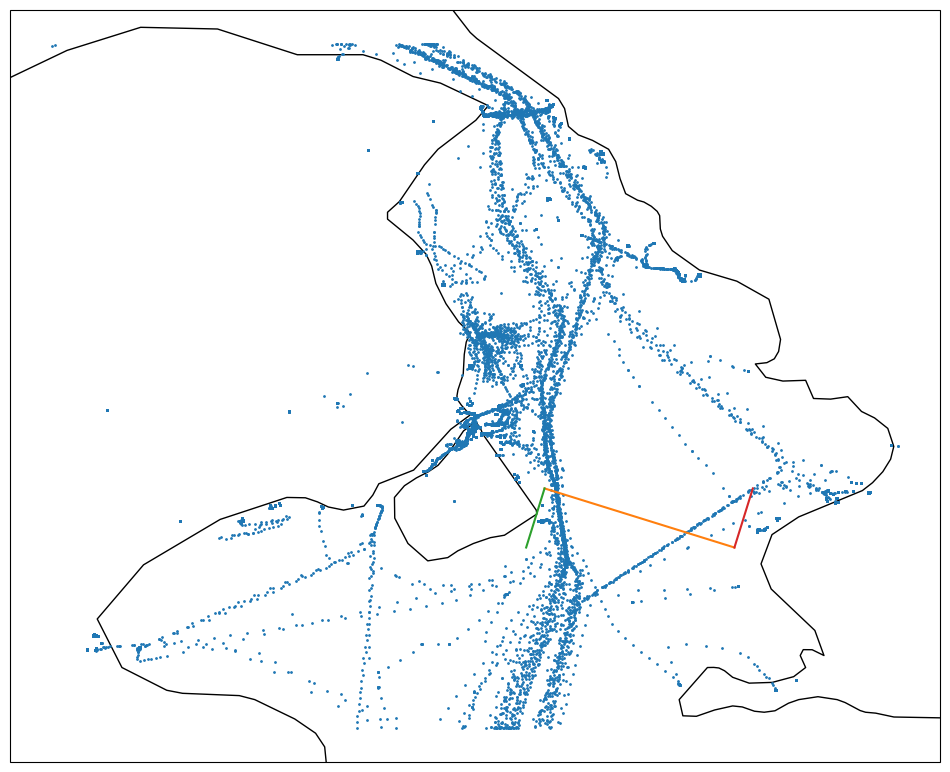

In [31]:
#Checking if everything is alright
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 12))
ax.plot(data['Longitude'], data['Latitude'], 'o', markersize=1, transform=ccrs.PlateCarree())
ax.plot(long_or, lat_or, transform=ccrs.PlateCarree())

lats = np.linspace(lat_or[0], lat_or[1], 100)

ax.plot(corridor_lon(lats)[0], lats, transform=ccrs.PlateCarree())
ax.plot(corridor_lon(lats)[1], lats, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)

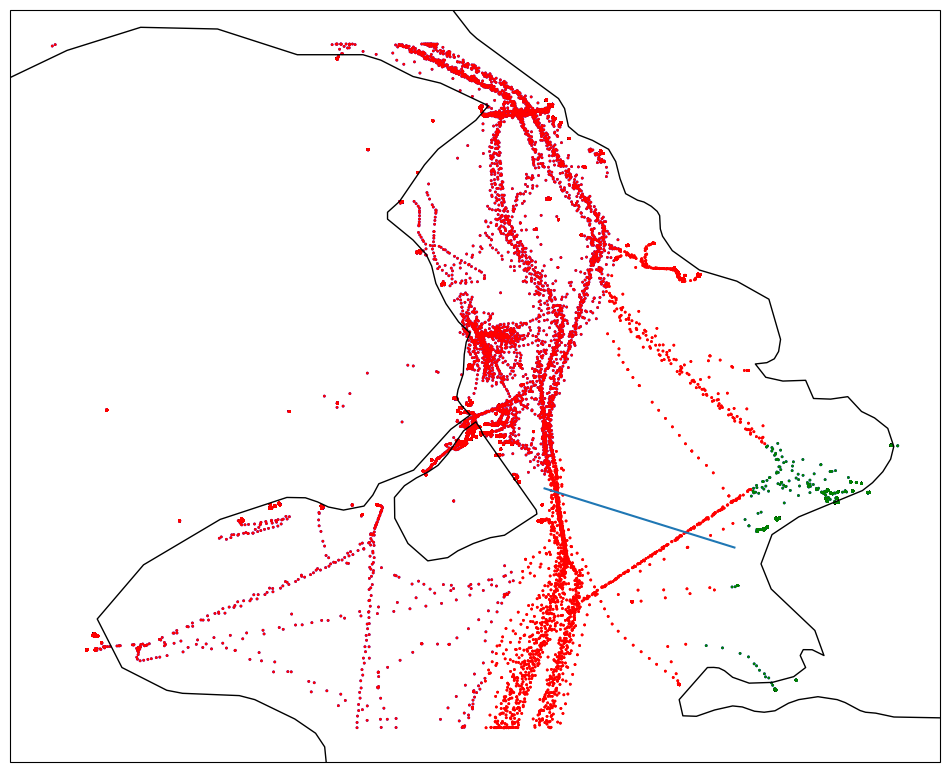

In [32]:
west, east = corridor_lon(data['Latitude'])
in_corridor = data['Longitude'].between(west, east)
west_of_corridor = data['Longitude'] < west
east_of_corridor = data['Longitude'] > east

#Checking if everything is alright
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 12))
ax.scatter(data['Longitude'], data['Latitude'], s=1, transform=ccrs.PlateCarree(), color=in_corridor.map({True: 'red', False: 'blue'}).values)
ax.scatter(data['Longitude'], data['Latitude'], s=1, transform=ccrs.PlateCarree(), color=east_of_corridor.map({True: 'green', False: 'red'}).values)
ax.plot(long_or, lat_or, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)

In [33]:
#Calculating the distance
lat_dist = 6378*2*np.pi/360
lon_dist = lat_dist * np.cos(lat_or[0]*np.pi/180)

x = data['Longitude']*lon_dist
y = data['Latitude']*lat_dist

x_or = np.array(long_or)*lon_dist
y_or = np.array(lat_or)*lat_dist

print(lon_dist, lat_dist)
bridge_vec_deg = np.array([1, slope_or]) #Bridge vector in degrees
bridge_vec_dist = bridge_vec_deg * np.array([lon_dist, lat_dist]) #Bridge vector in km
n = np.array([-bridge_vec_dist[1], bridge_vec_dist[0]]) #Normal vector to the bridge vector in km
n = n/np.linalg.norm(n) #Normalized normal vector
perp_dist = (x-x_or[0])*n[0] + (y-y_or[0])*n[1]
above = (perp_dist > 0)*2 - 1
dist_west = above*np.sqrt((x-x_or[0])**2 + (y-y_or[0])**2)
dist_east = above*np.sqrt((x-x_or[1])**2 + (y-y_or[1])**2)

data['Distance'] = perp_dist * in_corridor + dist_west * west_of_corridor + dist_east * east_of_corridor
data['Abs Distance'] = np.abs(data['Distance'])

62.8439975250724 111.31709969219834


0        27.468467
1        27.467686
2        27.468186
3        27.468877
4        27.467692
           ...    
67418    50.827000
67419    49.936317
67420    40.688491
67421    12.588169
67422     3.100035
Name: Distance, Length: 67423, dtype: float64


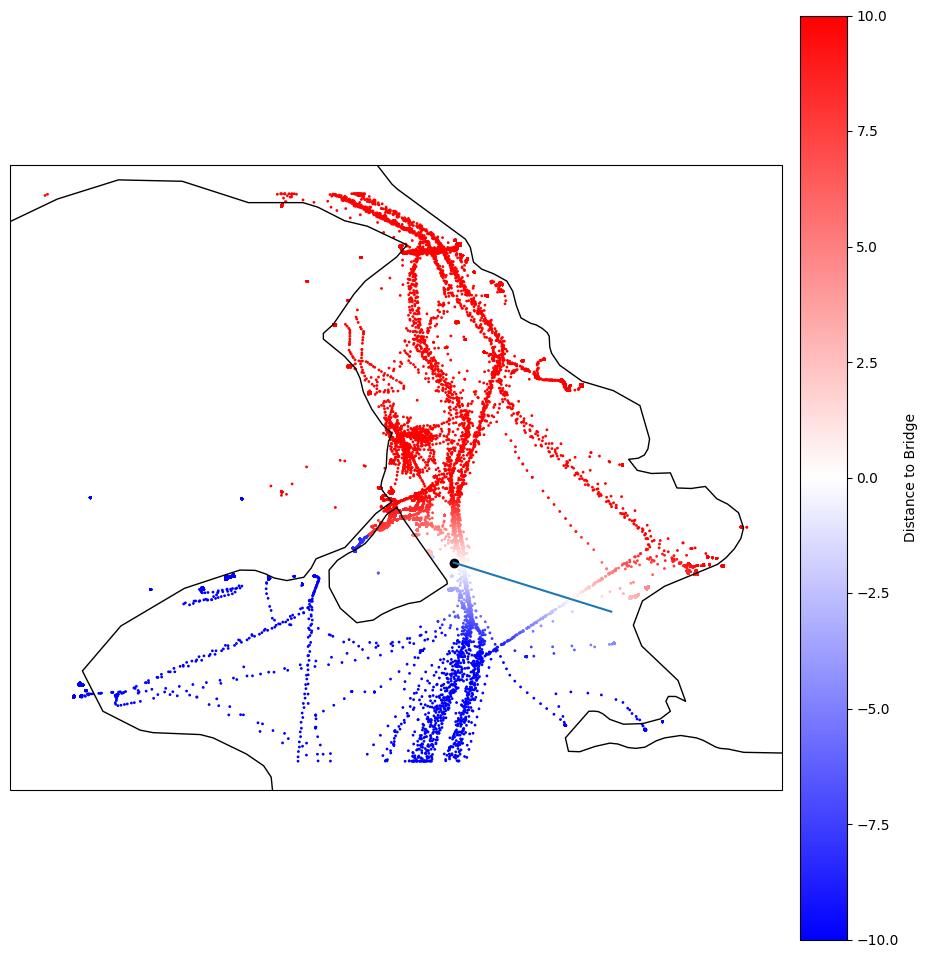

In [34]:
 #Checking if everything is alright
print(data['Distance'])

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 12))
ax.scatter(data['Longitude'], data['Latitude'], s=1, transform=ccrs.PlateCarree(), c=data['Distance'], cmap='bwr', vmin=-10, vmax=10)
ax.plot(long_or, lat_or, transform=ccrs.PlateCarree())
ax.scatter(long_or[0], lat_or[0], transform=ccrs.PlateCarree(), color='black')


cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Distance to Bridge')

# ax.set(ylim=(55.5, 55.7))
# ax.set_aspect('auto')

ax.add_feature(cfeature.COASTLINE)

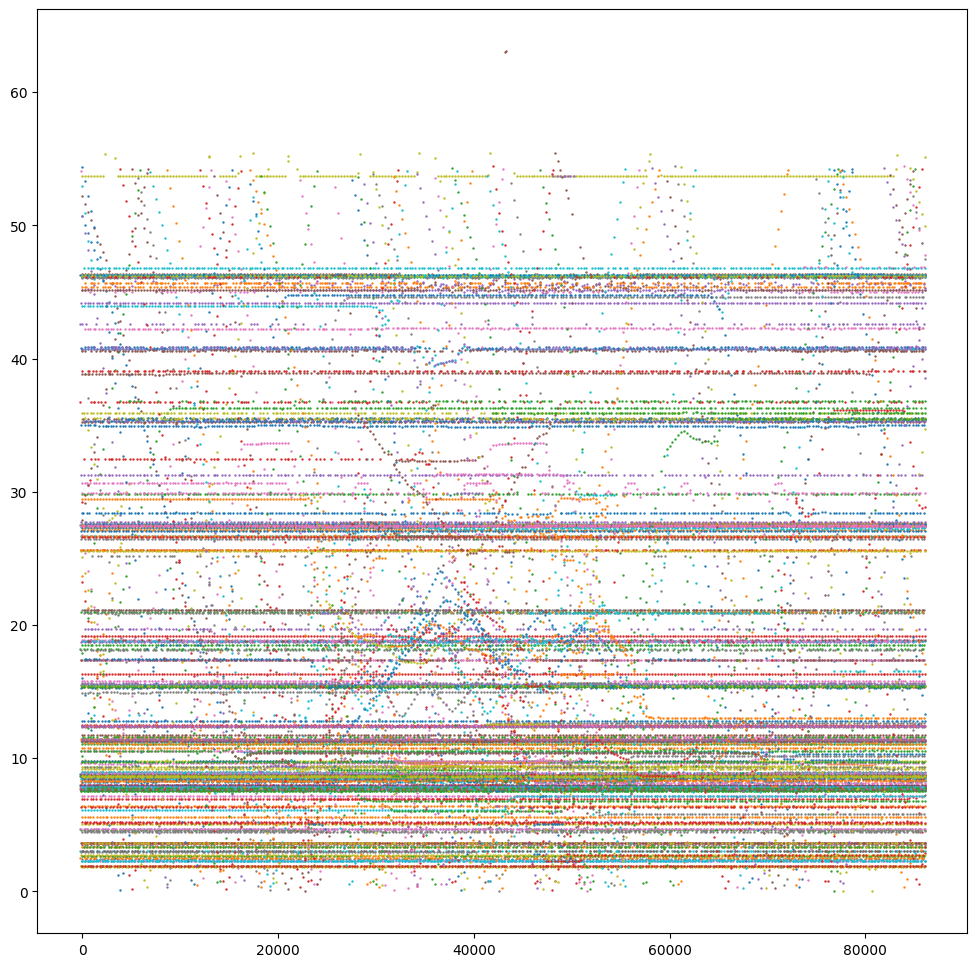

In [35]:
time = pd.to_datetime(data['# Timestamp'], dayfirst=True) #Creating a time column
time = time - time[0] #Setting the first time to 0
time_seconds = time.dt.total_seconds()
data['Time'] = time_seconds

plt.figure(figsize=(12, 12))

color_cycle = itertools.cycle(colors.TABLEAU_COLORS)

for MMSI, color in zip(data['MMSI'].unique(), color_cycle):
    data_MMSI = data[data['MMSI'] == MMSI]
    plt.scatter(data_MMSI['Time'], data_MMSI['Abs Distance'], color=color, s=.5)

/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_7512/4111211632.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_filter = pd.concat((data_filter, data_MMSI), ignore_index=True)
/Users/asger/.pyenv/versions/3.13.1/envs/base/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/asger/.pyenv/versions/3.13.1/envs/base/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_7512/4111211632.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  trial = np.mea

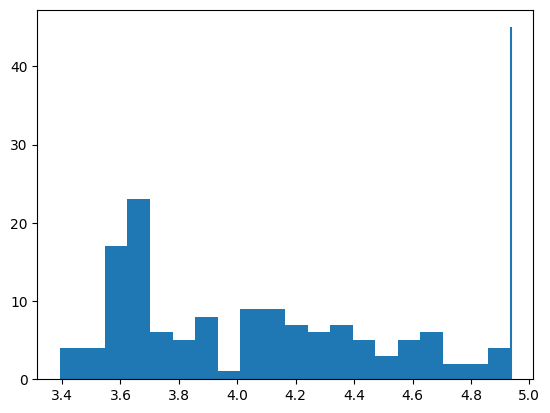

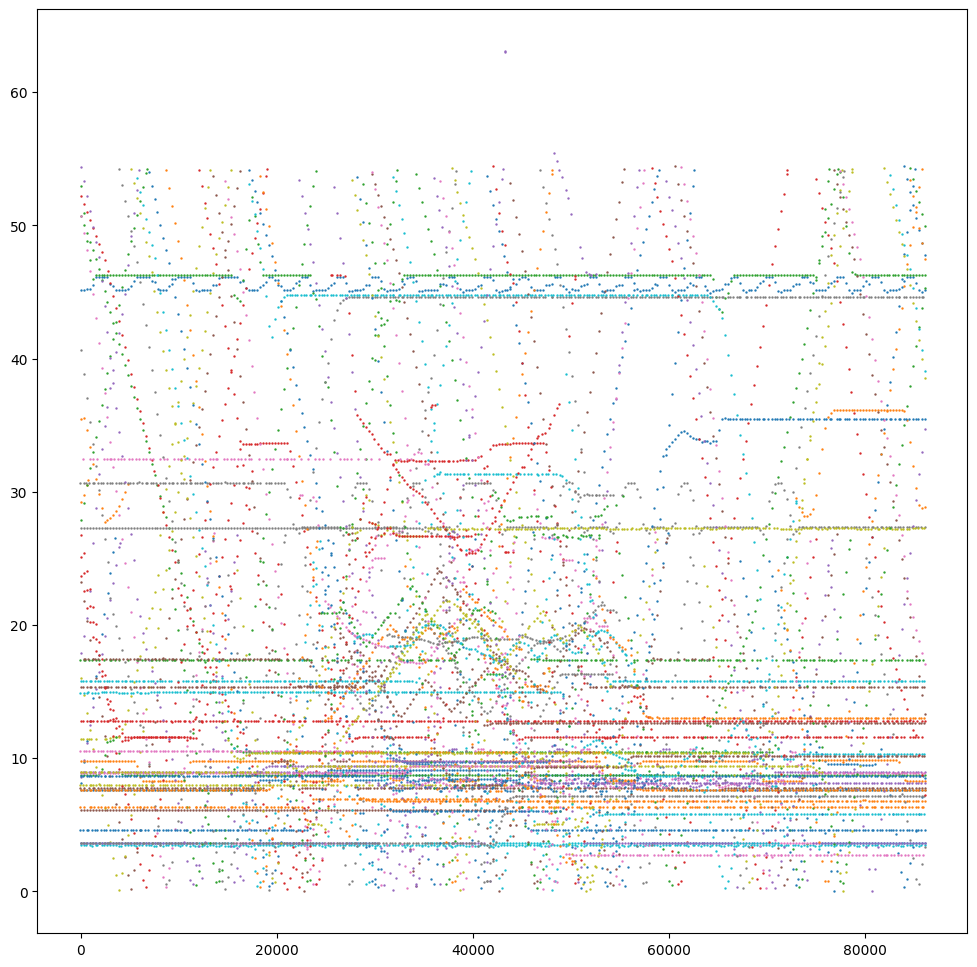

In [36]:
data_filter = pd.DataFrame(columns=data.columns)
means = []
for MMSI in data['MMSI'].unique():
    data_MMSI = data[data['MMSI']==MMSI]
    abs_dist, time = data_MMSI['Abs Distance'].values, data_MMSI['Time'].values
    abs_speed = np.abs(abs_dist[1:]-abs_dist[:-1])/(time[1:] - time[:-1])
    trial = np.mean(abs_dist)/np.mean(abs_speed)
    if trial != np.inf and trial < 24*60*60:
        means.append(trial)
        data_filter = pd.concat((data_filter, data_MMSI), ignore_index=True)

plt.figure()
plt.hist(np.log10(np.array(means)), bins=20)
plt.vlines(np.log10(24*60*60), 0, 45)
plt.figure(figsize=(12, 12))

color_cycle = itertools.cycle(colors.TABLEAU_COLORS)

for MMSI, color in zip(data_filter['MMSI'].unique(), color_cycle):
    data_MMSI = data_filter[data_filter['MMSI'] == MMSI]
    plt.scatter(data_MMSI['Time'], data_MMSI['Abs Distance'], color=color, s=.5)

In [37]:
#Criterion for crossing
data_filter_2 = pd.DataFrame(columns=data_filter.columns)
data_cross = dict()

dt = 5/60 #Sampling interval in hours
time_quarantine = 1*60*60 #TIme in seconds between potential multiple crossings
#It should also be able to detect multiple crossings
for MMSI in data_filter['MMSI'].unique():
    data_MMSI = data_filter[data_filter['MMSI'] == MMSI]
    dist_MMSI = data_MMSI['Distance'].values
    cross_line = ((dist_MMSI[1:]*dist_MMSI[:-1]) < 0) #Does it cross the line?
    crossings = np.where(cross_line)[0]
    if MMSI not in data_cross: #No overwriting stuff
        data_cross[MMSI] = []
    #This will be a criterion based on the geography of the area of interest. Now it is only the harbor of Copenhagen
    for crossing in crossings:
        if data_MMSI['Longitude'].values[crossing] > 12.665767:
            data_cross[MMSI].append(data_MMSI['Time'].values[crossing])
    
    #Just creating a dataset to plot
    if len(data_cross[MMSI])>0:
        data_filter_2 = pd.concat((data_filter_2, data_MMSI), ignore_index=True)

/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_7512/2296570652.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_filter_2 = pd.concat((data_filter_2, data_MMSI), ignore_index=True)


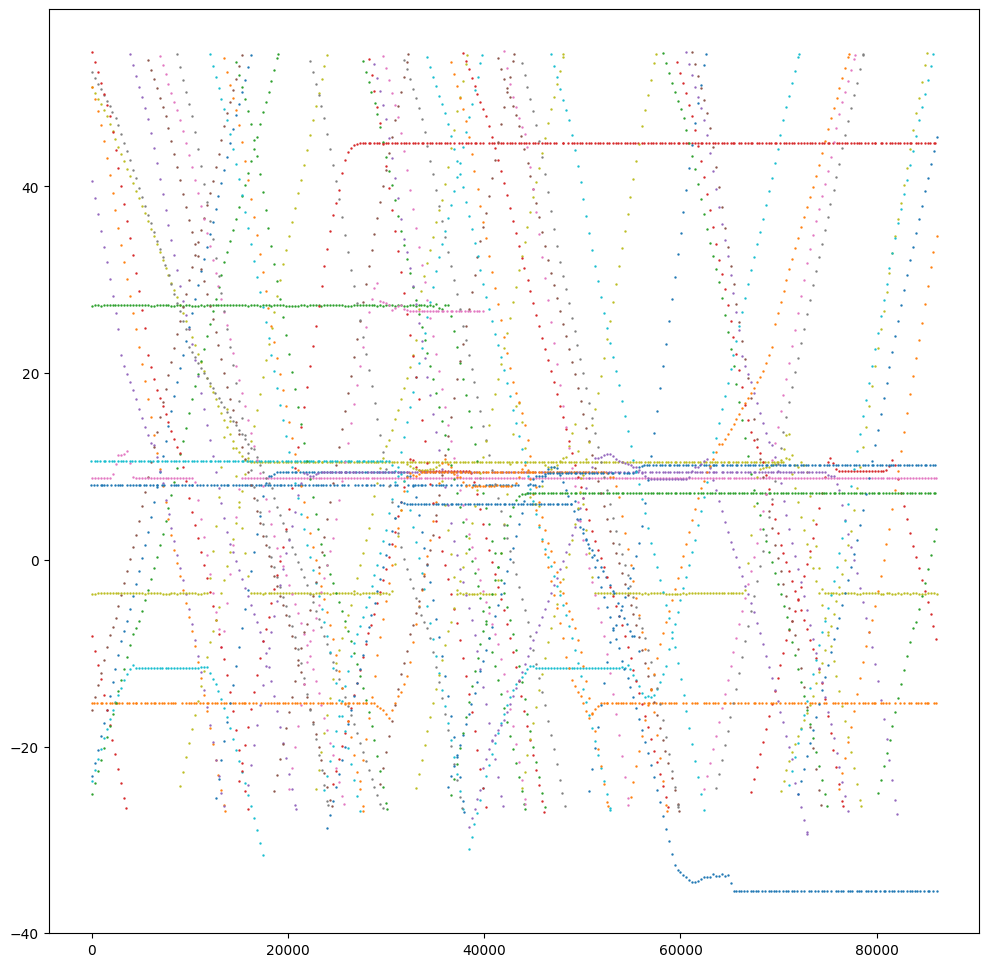

In [39]:
plt.figure(figsize=(12, 12))


for MMSI, color in zip(data_filter_2['MMSI'].unique(), color_cycle):
    data_MMSI = data_filter_2[data_filter_2['MMSI'] == MMSI]
    plt.scatter(data_MMSI['Time'], data_MMSI['Distance'], color=color, s=.5)

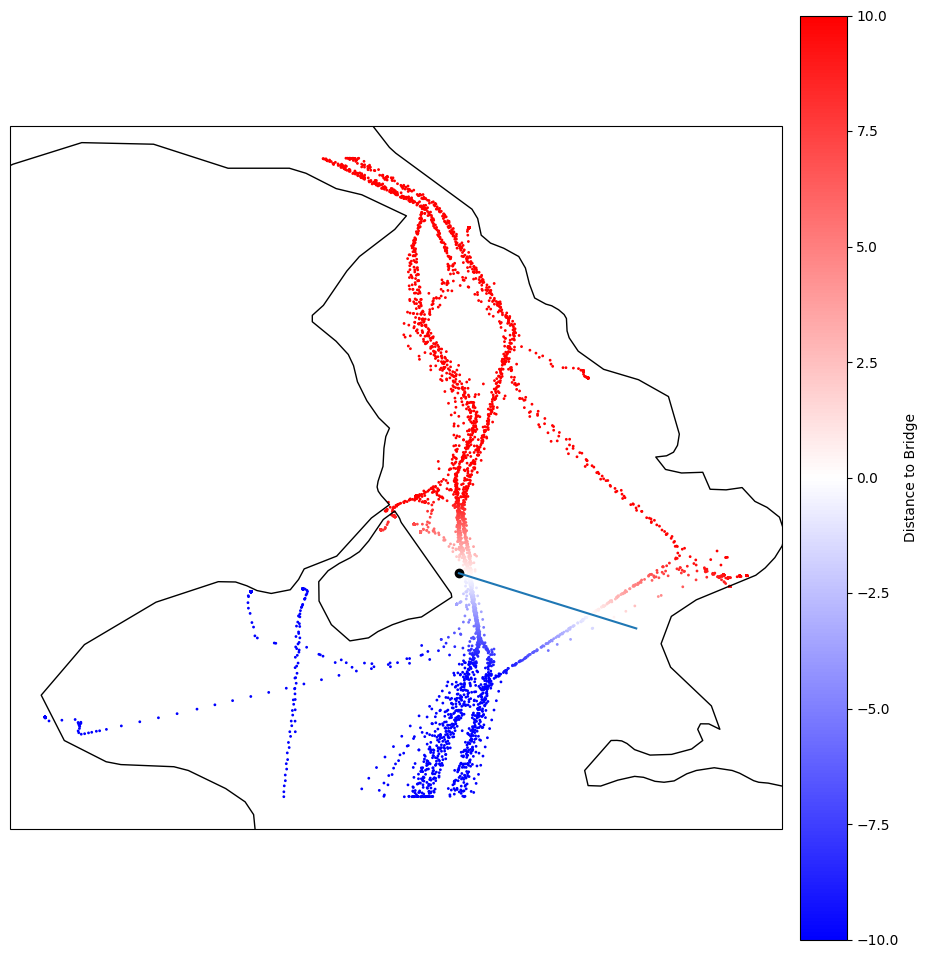

In [40]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 12))
ax.scatter(data_filter_2['Longitude'], data_filter_2['Latitude'], s=1, transform=ccrs.PlateCarree(), c=data_filter_2['Distance'], cmap='bwr', vmin=-10, vmax=10)
ax.plot(long_or, lat_or, transform=ccrs.PlateCarree())
ax.scatter(long_or[0], lat_or[0], transform=ccrs.PlateCarree(), color='black')


cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Distance to Bridge')

# ax.set(ylim=(55.5, 55.7))
# ax.set_aspect('auto')

ax.add_feature(cfeature.COASTLINE)

In [44]:
data_filter_2.columns, len(data_filter_2)

(Index(['# Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude',
        'Navigational status', 'SOG', 'COG', 'Heading', 'Ship type',
        'Cargo type', 'Width', 'Length', 'Destination', 'Distance',
        'Abs Distance', 'Time'],
       dtype='object'),
 5754)